In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import warnings
import os
import plotly.express as px
from sklearn.metrics import silhouette_score
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [5]:
df.drop(columns = 'CustomerID', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


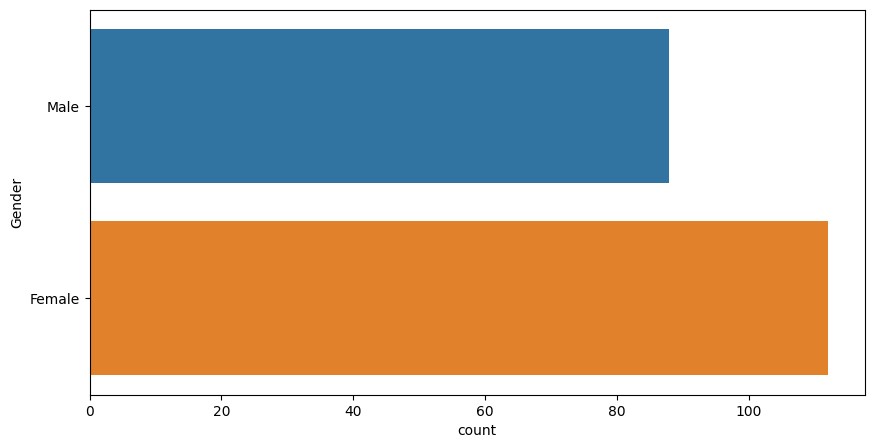

In [6]:
plt.figure(figsize = (10 , 5))
sns.countplot(y = 'Gender', data = df)
plt.show()

En nuestro dataset podemos ver que hay mas de 100 mujeres y al rededor de 85 hombres

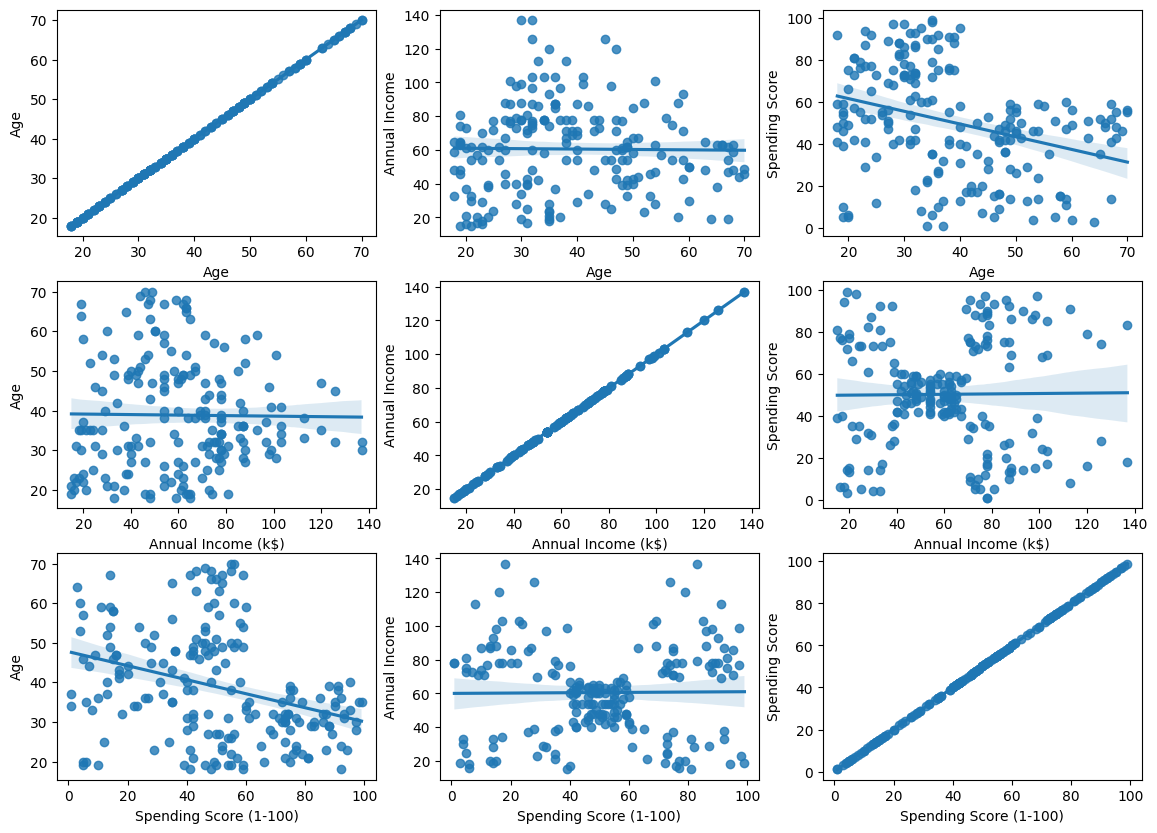

In [7]:
plt.figure(1 , figsize = (14 , 10))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        n += 1
        plt.subplot(3 , 3 , n)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0] + ' ' + y.split()[1] if len(y.split()) > 1 else y )
plt.show()

En estos scatter plots podemos ver que hay poca correlacion entre las diferentes caracteristicas de la data. En el caso de spending score y age, podemos ver que cuando la edad sube el spending score tiende a bajar. Esto nos indica una correlacion negativa relativamente fuerte entre estas caracteristicas. 

In [8]:
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    print(x.split())
    print(len(x.split()))

['Age']
1
['Annual', 'Income', '(k$)']
3
['Spending', 'Score', '(1-100)']
3


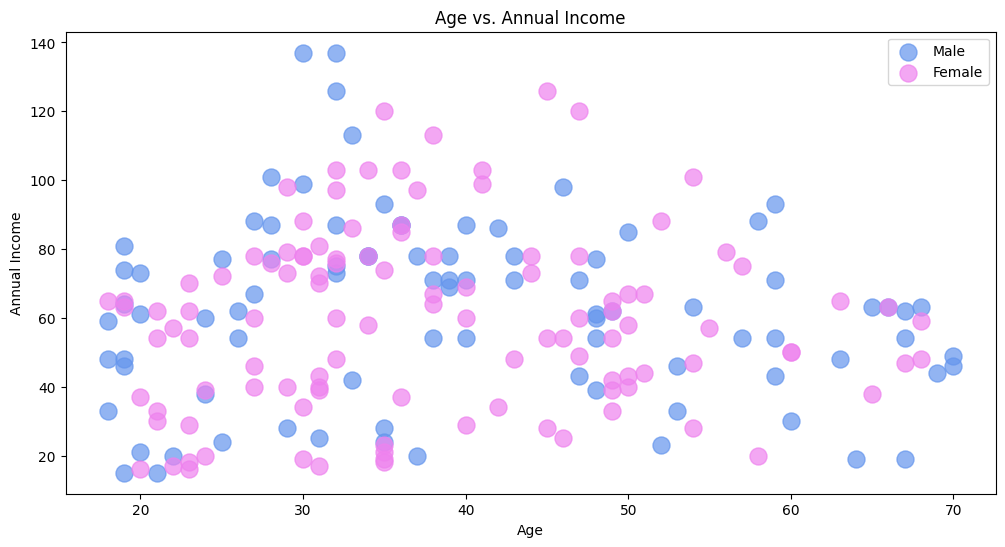

In [9]:
plt.figure(1 , figsize = (12 , 6))
for gender, color in zip(['Male', 'Female'], ['cornflowerblue', 'violet']):    
        plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender] ,
                    s = 150 , alpha = 0.7, label = gender, c = color)
plt.xlabel('Age'), plt.ylabel('Annual Income') 
plt.title('Age vs. Annual Income')
plt.legend()
plt.show()

En el grafico podemos ver edad y annual income por genero, basado en el grafico podemos concluir que no hay relacion lineal entre edad y annual income. Tampoco vemos que haya ninguna diferencia presente por genero, no vemos que los hombres o mujeres tienden a tener un annual income mas alto/bajo por genero.

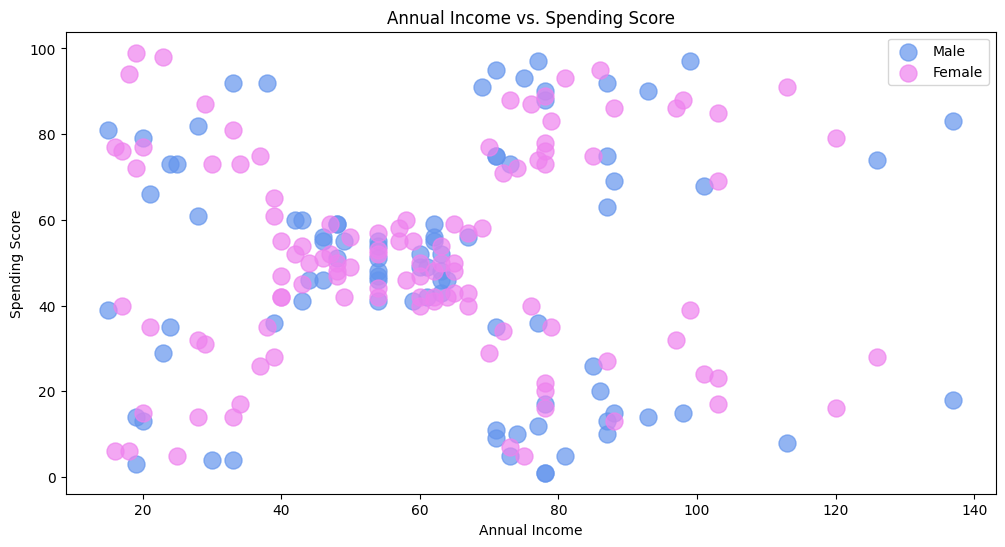

In [10]:
plt.figure(1 , figsize = (12 , 6))
for gender, color in zip(['Male', 'Female'], ['cornflowerblue', 'violet']):    
        plt.scatter(x = 'Annual Income (k$)' , y = 'Spending Score (1-100)' , data = df[df['Gender'] == gender] ,
                    s = 150 , alpha = 0.7, label = gender, c = color)
plt.xlabel('Annual Income'), plt.ylabel('Spending Score') 
plt.title('Annual Income vs. Spending Score')
plt.legend()
plt.show()

Entre annual income y spending score tampoco se puede ver una relacion lineal presente. De igual manera, tampoco vemos que el genero impacte alguna de estas caracteristicas.

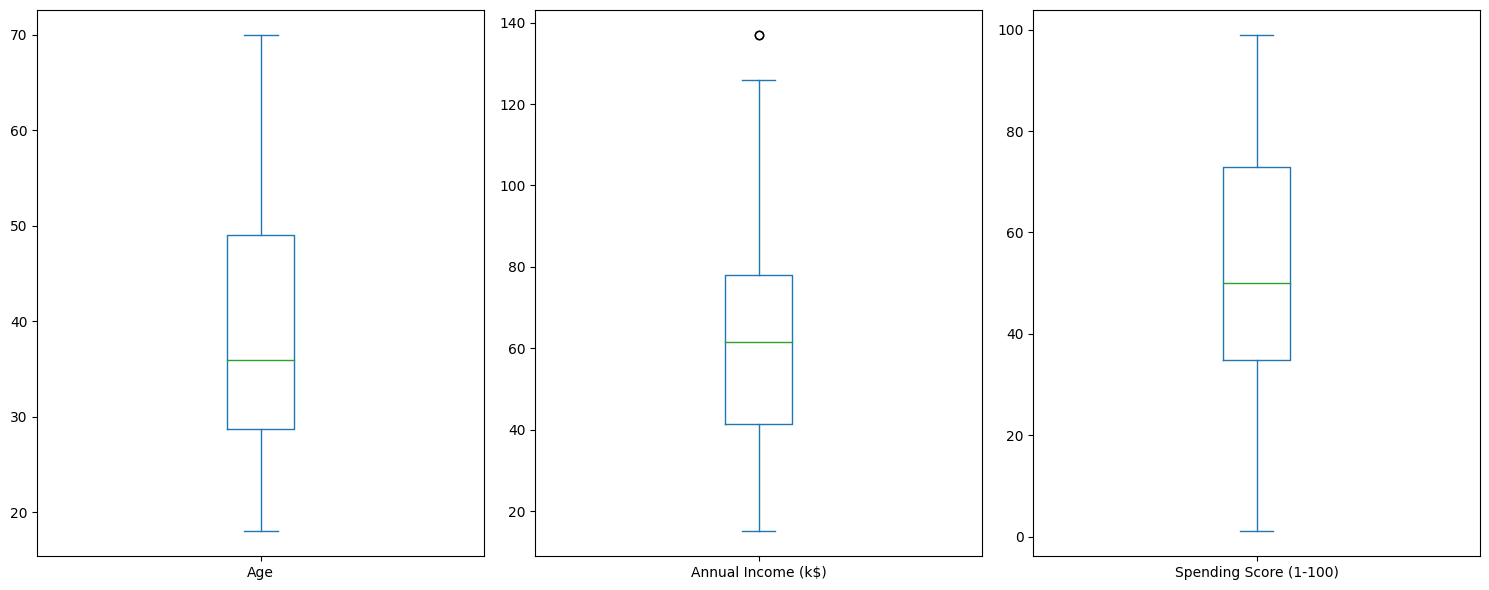

In [11]:
df.plot(kind='box', subplots=True, figsize=(15, 6))
plt.tight_layout()
plt.show()

En los boxplots, podemos ver que la data no tiene valores a tipicos, solo uno en annual income. 

In [12]:
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

In [13]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


In [14]:
df.dtypes

Gender                    int64
Age                       int64
Annual Income (k$)        int64
Spending Score (1-100)    int64
dtype: object

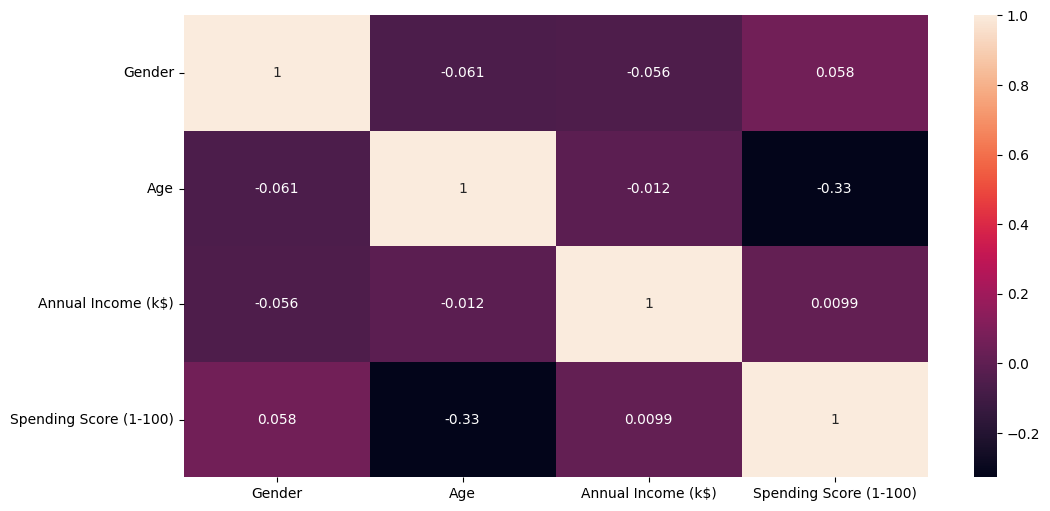

In [15]:
plt.figure(figsize=(12,6))
cor = df.corr()
sns.heatmap(cor, annot=True)
plt.show()

En edad y spending score podemos ver una correlacion negativa de 0.33, esto nos indica que mientras el valor de uno sube, el otro tiende a bajar.

Las otras caracteristicas tienen correlaciones muy bajas, que no nos indica relacion entre ellas.

## Segmentacion con Annual Score, Age y Spending Score

In [16]:
X = df[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values

In [17]:
X

array([[ 19,  15,  39],
       [ 21,  15,  81],
       [ 20,  16,   6],
       [ 23,  16,  77],
       [ 31,  17,  40],
       [ 22,  17,  76],
       [ 35,  18,   6],
       [ 23,  18,  94],
       [ 64,  19,   3],
       [ 30,  19,  72],
       [ 67,  19,  14],
       [ 35,  19,  99],
       [ 58,  20,  15],
       [ 24,  20,  77],
       [ 37,  20,  13],
       [ 22,  20,  79],
       [ 35,  21,  35],
       [ 20,  21,  66],
       [ 52,  23,  29],
       [ 35,  23,  98],
       [ 35,  24,  35],
       [ 25,  24,  73],
       [ 46,  25,   5],
       [ 31,  25,  73],
       [ 54,  28,  14],
       [ 29,  28,  82],
       [ 45,  28,  32],
       [ 35,  28,  61],
       [ 40,  29,  31],
       [ 23,  29,  87],
       [ 60,  30,   4],
       [ 21,  30,  73],
       [ 53,  33,   4],
       [ 18,  33,  92],
       [ 49,  33,  14],
       [ 21,  33,  81],
       [ 42,  34,  17],
       [ 30,  34,  73],
       [ 36,  37,  26],
       [ 20,  37,  75],
       [ 65,  38,  35],
       [ 24,  38

In [18]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
y_kmeans = kmeans.labels_

print('kmeans inertia:',kmeans.inertia_)
print('kmeans pred:',y_kmeans)
print('kmeans labels_:',kmeans.labels_)

kmeans inertia: 58300.44332159069
kmeans pred: [0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0
 3 0 3 1 3 1 2 0 3 1 2 2 2 1 2 2 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1
 1 2 1 2 2 1 1 2 1 1 2 1 1 2 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 1 2 1 1 1 1 1
 2 2 2 2 2 1 1 1 1 2 2 2 4 2 4 5 4 5 4 5 4 2 4 5 4 5 4 5 4 5 4 2 4 5 4 5 4
 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5
 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4]
kmeans labels_: [0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0
 3 0 3 1 3 1 2 0 3 1 2 2 2 1 2 2 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1
 1 2 1 2 2 1 1 2 1 1 2 1 1 2 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 1 2 1 1 1 1 1
 2 2 2 2 2 1 1 1 1 2 2 2 4 2 4 5 4 5 4 5 4 2 4 5 4 5 4 5 4 5 4 2 4 5 4 5 4
 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5
 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4]


In [19]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
labels = kmeans.labels_

score = silhouette_score(X, labels)
print("Silhouette Score: {:.2f}".format(score))

Silhouette Score: 0.45


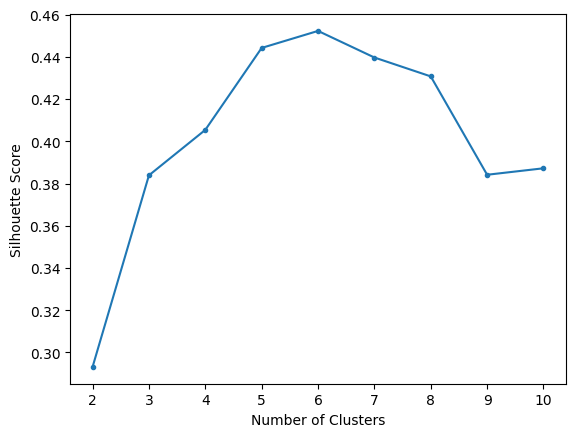

In [20]:
silhouette_scores_list = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(X)
  silhouette_scores_list.append(silhouette_score(X, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores_list, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

En este grafico, vemos el pico cuando el numero de clusters es 6. Por eso, decidi utilizar 6 clusters.

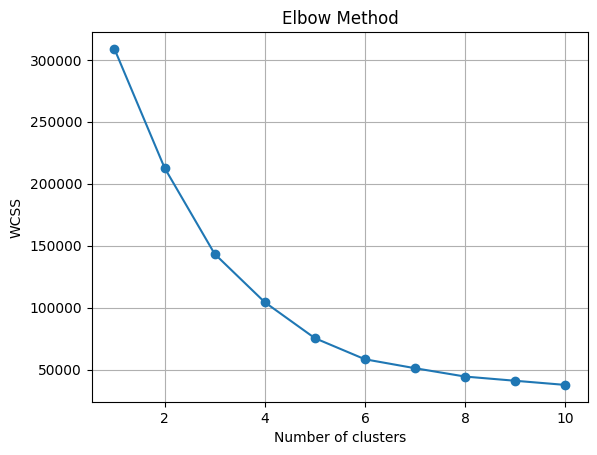

In [21]:
wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_) 

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Usando el metodo del codo, podemos ver que el la diferencia entre WCSS empieza a ser poco significativa luego de el numero de clusters 6. En base a esto, y a el grafico anterior, decidi utilizar 6 numero de clusters.

In [22]:
fig = px.scatter_3d(
    x=X[:, 0],
    y=X[:, 1],  
    z=X[:, 2],  
    color=kmeans.labels_,  
    title="3D scatter plot with 6 clusters"
)

centroids = kmeans.cluster_centers_
fig.add_scatter3d(
    x=centroids[:, 0],
    y=centroids[:, 1],
    z=centroids[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color='lime',
        symbol='cross'
    ),
    name='Centroids'
)

fig.update_layout(
    scene=dict(
        xaxis_title='Age',
        yaxis_title='Annual Income',
        zaxis_title='Spending Score'
    ),
    width=1200,
    height=1000
)

fig.show()


In [23]:
df2 = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

In [24]:
predicted_labels = kmeans.labels_

In [25]:
df2['Cluster_Label'] = predicted_labels

df2.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster_Label
0,1,Male,19,15,39,5
1,2,Male,21,15,81,1
2,3,Female,20,16,6,4
3,4,Female,23,16,77,1
4,5,Female,31,17,40,5


# Conclusiones

* La categoria 0 tienen un spending score en el medio (entre 40 y 60), son del rango mas alto de edad (40-70 años), y annual income entre 39-67 mil (medio-bajo en comparacion a el rango)

* La categoria 1 tiene entre 27 y 40 años de edad, un annual income entre 69 y 137 mil (alto), y un spending score entre 63 y 97 (alto)

* La categoria 2 tienen un annual income entre 71 y 137 (alto), pero un spending score bajo (entre 1 y 39), y el rango de edad es entre 19 y 59

* La categoria 3 tienen un annual income entre 20-40 mil, son del grupo mas joven (entre 18 y 40 años), pero son de nivel alto de spending score (entre 80 y 100)

* La categoria 4 tiene un annual income entre 15-40 (bajo), un spending score entre 0-40 (bajo), y estan en todos los rangos de edad (jovenes y mayores)

* La categeoria 5 son del rango de edad de 18 y 40 años, spending score entre 29 y 61 (medio), y annual income entre 39 y 76 mil (medio)

# Decisiones:

En base a esto, podemos decidir que los clientes (que tienen la carta de membresia) de categoria 2 y 4 no son una buena opcion para gastar muchos recursos en ellos ya que no gastan mucho en la tienda. Los clientes de categoria 0 y 5 tienen un spending score medio. A la categoria 0, podemos mandarle ofertas y productos mas asequibles ya que son del rango de annual income medio-bajo y ver si esto ayuda a mejorar su spending score, si no ayuda, podemos parar de gastar recursos en ellos. Para la categoria 5 que son de un annual income medio se les puede promocionar productos de mayor precio, y de igual manera monitorear si el marketing dirigido hacia ellos hace algun cambio en sus gastos en la tienda. Como la categoria 3 tiene un nivel relativamente bajo de annual income, se puede enfocar mas su marketing en ofertas y productos de mas bajo costo. Para la categoria 1, ya que tienen un annual income bastante alto, podemos mandarle ofertas y informacion sobre productos de mas alto costo, que pudiera ser de su interes.